In [35]:
import matplotlib.pyplot as plt

In [54]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose


transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
fdataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
test = FashionMNIST(root="./data", train=False, download=True, transform=transform)
dataloader = DataLoader(fdataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test,    batch_size=64)

images, labels = next(iter(dataloader))
print(f"{images.shape} {labels.shape}")

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import random


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

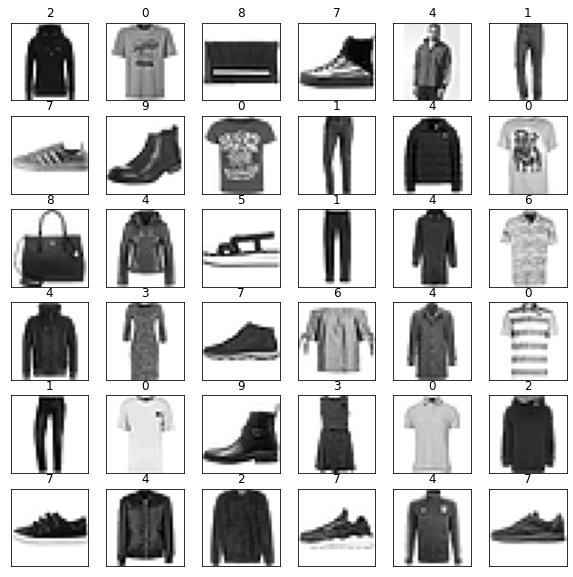

In [57]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names = list(range(10))
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(images[i]).reshape((28,28)),cmap="binary")
    label_index = int(labels[i])
    plt.title(class_names[label_index])
plt.show()

In [67]:
class VAE(nn.Module):
    def __init__(self, imageChannels=1, featureDim=32*20*20, zdim=32):
        super(VAE, self).__init__()
        
        self.enConv1 = nn.Conv2d(imageChannels, 16, 5)
        self.enConv2 = nn.Conv2d(16, 32, 5)
        self.enFC1 = nn.Linear(featureDim, zdim)
        self.enFC2 = nn.Linear(featureDim, zdim)
        
        self.deFC1 = nn.Linear(zdim, featureDim)
        self.deConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.deConv2 = nn.ConvTranspose2d(16, imageChannels, 5)
        
    def encoder(self, x):
        
        x = F.relu(self.enConv1(x))
        x = F.relu(self.enConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.enFC1(x)
        logVar = self.enFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        std = torch.exp(logVar /2)
        eps = torch.rand_like(std)
        
        return mu + eps* std
        
        
    def decoder(self, z):
        x = F.relu(self.deFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.deConv1(x))
        x = torch.sigmoid(self.deConv2(x))
        return x
    
    def forward(self, x):
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
        
    
                

In [68]:
batch_size = 128*4
learning_rate = 1e-3
num_epochs = 30

In [69]:
np.array(images).dtype

dtype('float32')

In [70]:
net = VAE().to(device)

In [71]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [72]:
for epoch in range(num_epochs):
    for idx, data in enumerate(dataloader, 0):
        imgs, _ =data
        imgs = imgs.view(-1, 1,  28, 28)
        imgs = imgs.float()
        imgs = imgs.to(device)
        out, mu, logVar = net(imgs)
        
        # loss function
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch {}: Loss {}'.format(epoch, loss))


Epoch 0: Loss -1082399.25
Epoch 1: Loss -1114310.0
Epoch 2: Loss -1263555.0
Epoch 3: Loss -1223395.375
Epoch 4: Loss -1159375.875
Epoch 5: Loss -1384926.625
Epoch 6: Loss -1301710.5
Epoch 7: Loss -1296633.75
Epoch 8: Loss -1179892.0
Epoch 9: Loss -1308803.625
Epoch 10: Loss -1392922.0
Epoch 11: Loss -1307232.375
Epoch 12: Loss -1308020.875
Epoch 13: Loss -1291473.5
Epoch 14: Loss -1454848.75
Epoch 15: Loss -1405029.0
Epoch 16: Loss -1460693.0
Epoch 17: Loss -1384796.0
Epoch 18: Loss -1289257.125
Epoch 19: Loss -1481210.125
Epoch 20: Loss -1481024.25
Epoch 21: Loss -1495070.625
Epoch 22: Loss -1458031.25
Epoch 23: Loss -1377631.125
Epoch 24: Loss -1477755.625
Epoch 25: Loss -1395246.75
Epoch 26: Loss -1470628.125
Epoch 27: Loss -1546236.125
Epoch 28: Loss -1416599.375
Epoch 29: Loss -1535668.75


In [73]:
imgs.shape

torch.Size([32, 1, 28, 28])

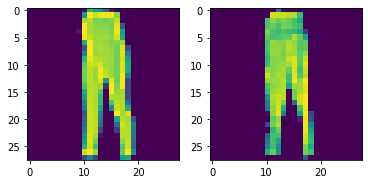

In [74]:
import numpy as np
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.view(-1, 1,  28, 28)
        imgs = imgs.float()
        imgs = imgs.to(device)
        out, mu, logVAR = net(imgs)
        plt.subplot(121)
        plt.imshow(imgs[0, 0].cpu().numpy())
        plt.subplot(122)
        plt.imshow(out[0, 0].cpu().numpy())
        break